In [1]:
import os
import random
import pprint
import sys
import time
import numpy as np
import pickle
import math
import cv2
import copy
from optparse import OptionParser
from matplotlib import pyplot as plt
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import pandas as pd

from sklearn.metrics import average_precision_score
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Layer, Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils import layer_utils, get_source_inputs
from keras.utils import generic_utils
from keras.utils.data_utils import get_file
from keras.losses import categorical_crossentropy
from keras.engine.input_spec import InputSpec
from keras.models import Model
from keras import initializers, regularizers

from faster_rcnn_utils import *

#### To test the Faster R-CNN model, we use the annotation file obtained from preprocessing step 

In [2]:
# Path to the annotation file 
test_path = './data/annotations/test_annotation.txt' 

# Path to the test images
test_base_path = './data/images/test'

# Path to the config file 
config_output_filename = os.path.join('./weights_and_config/model_vgg_config.pickle')

### Set up configuration

In [3]:
# Load the config file
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# No augmentation while testing the model
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

### Format the images based on configuration

In [5]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

### Build the model

In [6]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=False)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

In [7]:
# Load the weights obtained from training
print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

# Compile
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from model_frcnn_vgg.hdf5


In [8]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Bottle', 1: 'bg'}


## Test the model

In [9]:
# Read test images
test_imgs = os.listdir(test_base_path)

all_imgs = []
classes = {}

039c0685a7bd08d7.jpg
1/1 [==============================] - 0s 38ms/step


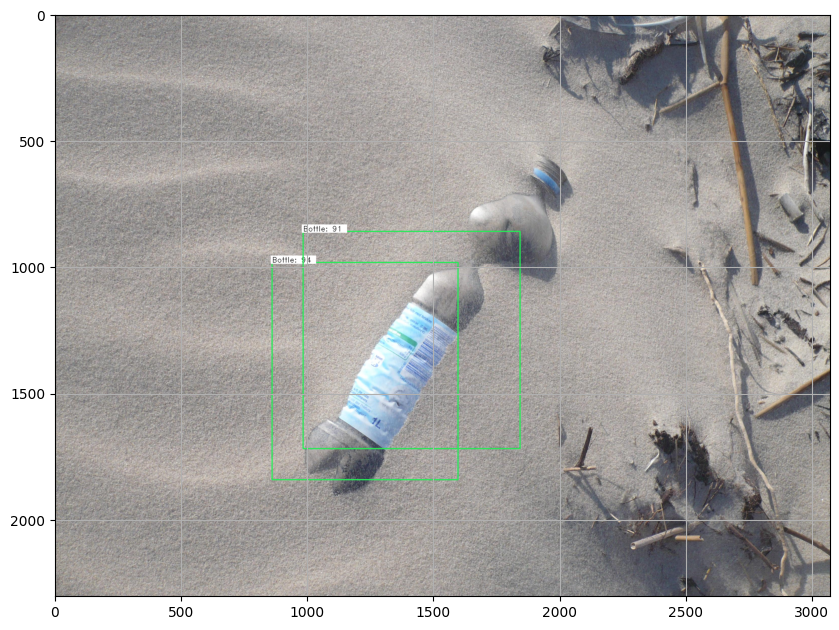

20aad7750c39329a.jpg
1/1 [==============================] - 0s 42ms/step


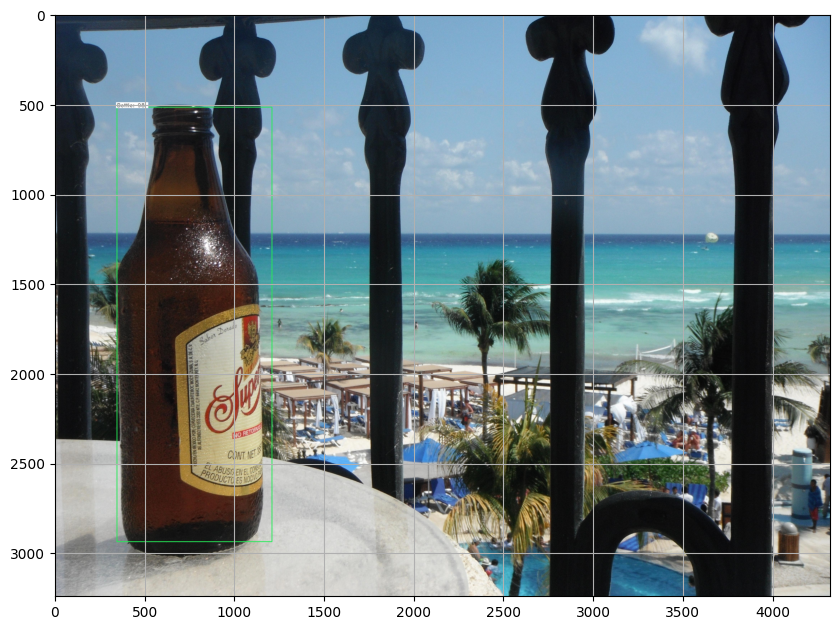

45257b7923217893.jpg
1/1 [==============================] - 0s 44ms/step


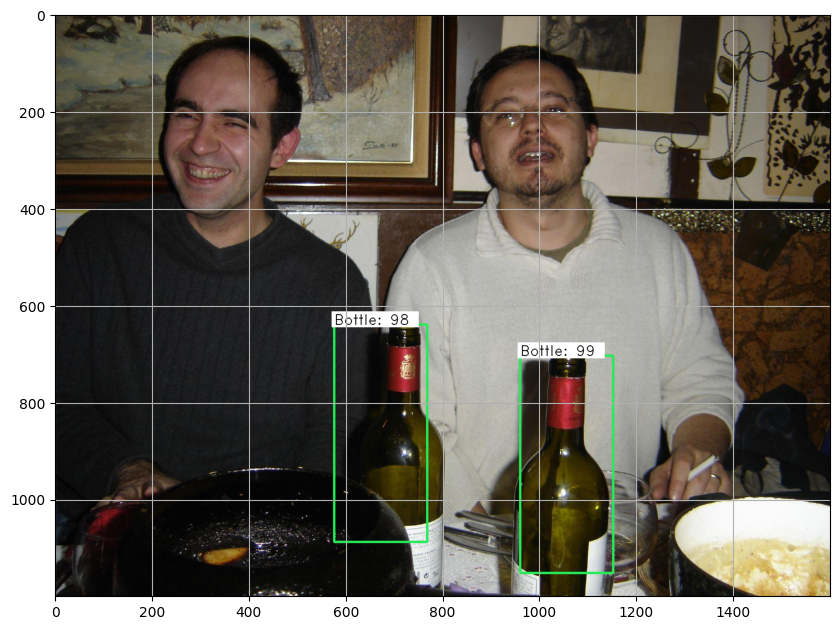

8b2bd24c6abc7b8f.jpg
1/1 [==============================] - 0s 45ms/step


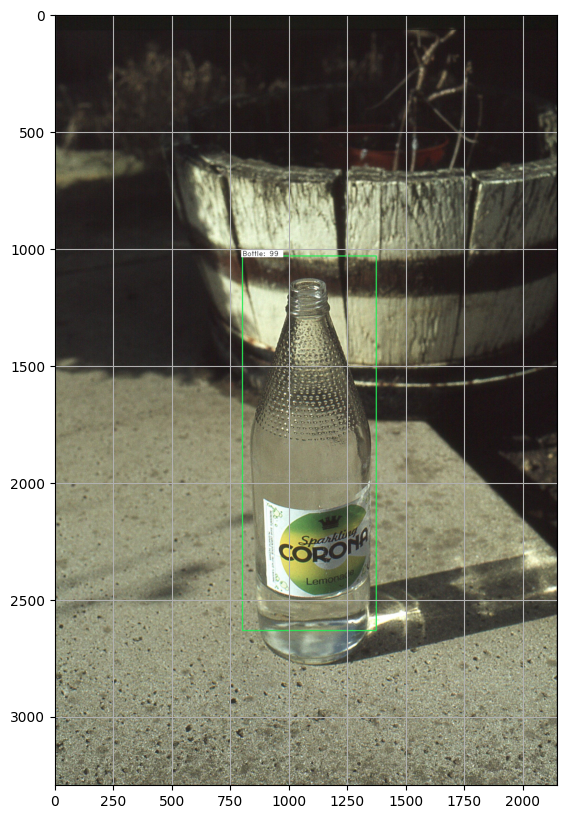

dc460da02046d6a8.jpg
1/1 [==============================] - 0s 46ms/step


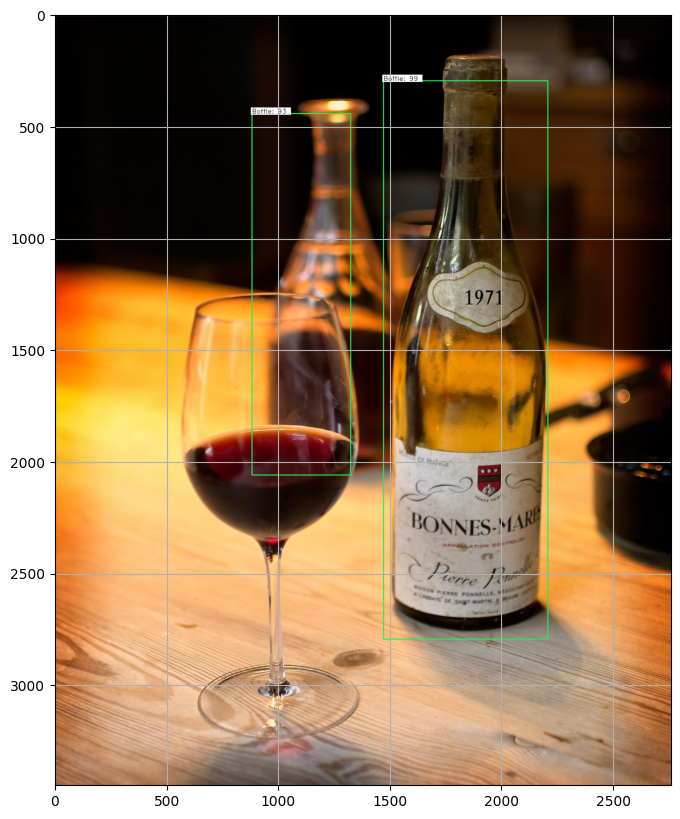

dea12e9e78df007e.jpg
1/1 [==============================] - 0s 42ms/step


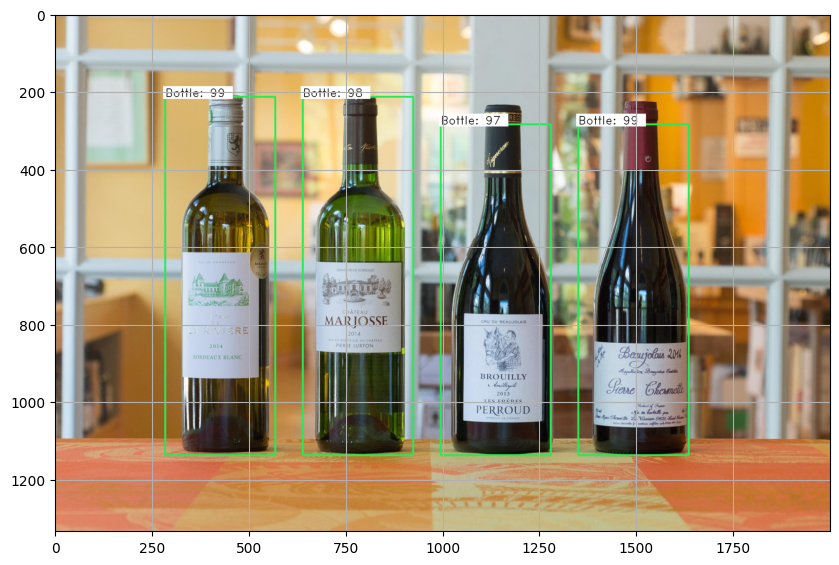

In [10]:
# The box won't be shown if its class score is less than bbox_threshold
bbox_threshold = 0.6

# Loop over the images
for idx, img_name in enumerate(test_imgs):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)
    # Read the image
    img = cv2.imread(filepath)
    X, ratio = format_img(img, C)
    X = np.transpose(X, (0, 2, 3, 1))

    # Get output layer Y1, Y2 and feature map F from RPN
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.9)

    # Convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # Apply the spatial pyramid pooling to proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bbox coordinates for resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates of bboxes for original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
            # Draw the bbox
            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

# Prepare data for fine-tuning the U-Net model

After observing the performance of the trained Faster R-CNN in detecting bottles, we aim to integrate its outputs as inputs for our U-Net model. Specifically, the process is as follows:

1. Object Detection with Faster R-CNN: Given an image, the Faster R-CNN identifies the presence of bottles and draws bounding boxes around them.

2. Cropping and Image Preparation: The area inside the bounding box is then cropped and prepared as input for the U-Net model.

3. Semantic Segmentation with U-Net: Upon receiving the cropped image, U-Net performs binary segmentation, identifying pixels associated with the 'bottle' class.

#### However, there is a challenge with this approach:
As illustrated in the preceding images, the bounding boxes generated by the Faster R-CNN are rather tight. This presents two concerns:

1. Dataset Inconsistency: The predominant feature in the Faster R-CNN's output image is the bottle. This differs from the distribution observed in the U-Net's training dataset.
2. Data Loss: Tight bounding boxes might exclude portions of the detected objects, leading to incomplete representations when cropped.

#### Proposed Solutions:

Addressing Dataset Inconsistency: We can fine-tune U-Net using the cropped images obtained from the Faster R-CNN's outputs. This realigns U-Net's familiarity with the newer distribution.

Addressing Data Loss: we enlarge the bounding boxes before cropping the image. The object's mask is also cropped based on the expanded bounding box. These new images and masks are then used to fine-tune U-Net.

In [ ]:
def process_image(img, x1, y1, x2, y2, img_name, scale=0.1, save_dir='data_for_fine-tuning_U-Net/cropped_images'):
    """
    Scales the bounding box, crops the images based on these 
    coordinates and saves the image
    """
    # Calculate coordinates for cropping with scaling
    width = x2 - x1
    height = y2 - y1
    center_x, center_y = x1 + width // 2, y1 + height // 2

    new_width = int(width * (1 + scale*2))
    new_height = int(height * (1 + scale))

    new_x1 = max(0, center_x - new_width // 2)
    new_y1 = max(0, center_y - new_height // 2)
    new_x2 = min(img.shape[1], center_x + new_width // 2)
    new_y2 = min(img.shape[0], center_y + new_height // 2)

    # Crop the image
    cropped_img = img[new_y1:new_y2, new_x1:new_x2]

    # Save the cropped image
    save_name = f"{str(jk)}_{img_name}"
    save_path = os.path.join(save_dir, save_name)
    cv2.imwrite(save_path, cropped_img)

    return new_x1, new_y1, new_x2, new_y2


In [59]:
def process_mask(real_x1, real_y1, real_x2, real_y2, mask_path, save_directory):
    # Read the mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is grayscale
    
    # Crop the mask using provided coordinates
    cropped_mask = mask[real_y1:real_y2, real_x1:real_x2]
    
    mask_name = os.path.basename(mask_path)
    
    # Save the cropped mask to the specified directory
    save_path = os.path.join(save_directory, mask_name)
    cv2.imwrite(save_path, cropped_mask)
    
    return save_path 

In [ ]:
# Read the image names 
img_names = os.listdir('./data_for_fine-tuning_U-Net/original_images/images')
   
all_imgs = []

classes = {}

In [ ]:
# The box will be ignored in case its classification score is less than bbox_threshold
bbox_threshold = 0.6

for idx, img_name in enumerate(img_names):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join('data_for_fine-tuning_U-Net/original_images/images', img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.9)

    # Convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # Apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5, max_boxes=1)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
            
            # Enlarge the bounding box by 30% and
            # Crop the image using the enlarged bounding box, then save it 
            real_x1, real_y1, real_x2, real_y2 = process_image(img, real_x1, real_y1, real_x2, real_y2, img_name, scale=0.3)
            
            mask_path = os.path.join('./data_for_fine-tuning_U-Net/original_masks/masks', img_name)
            save_directory = './data_for_fine-tuning_U-Net/cropped_masks'
            # Crop the corresponding mask as well and save it
            process_mask(real_x1, real_y1, real_x2, real_y2, mask_path, save_directory)